In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
# from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


# Case 1

10.0

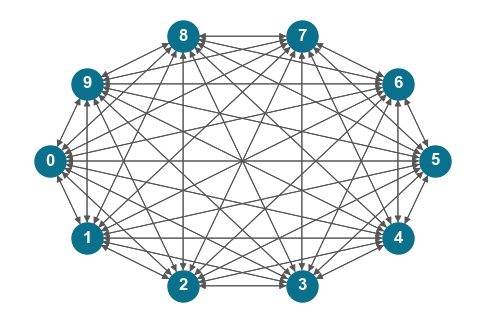

In [3]:
graph_1, edge_list_1, node_list_1 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)

# nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)
maxentep.draw_graph(graph_1, dpi =100)
dof_1 = maxentep.graph_dof(graph_1.edges(), node_list_1)
dof_1

Reference Model

In [4]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
# mobility_matrix[1,:]= 0
# mobility_matrix[:,1]= 0
mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(mobility_matrix, mobility_matrix_diag)
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(mobility_matrix))
# np.diagonal(mobility_matrix)
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


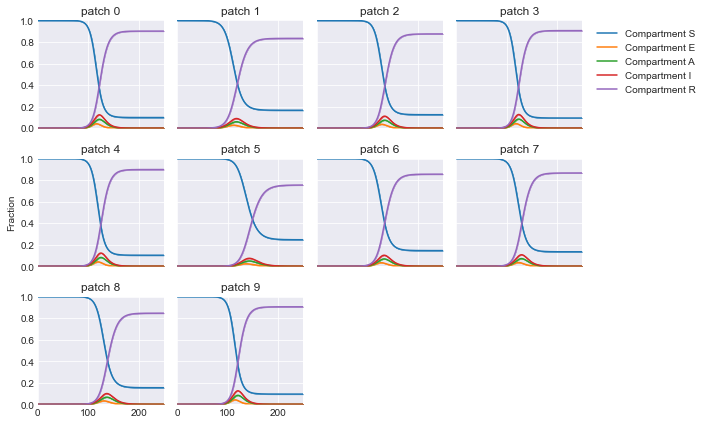

In [5]:
def gen_ref_traj(beta_A = 0.025, beta_I=0.04, alpha =1/3, gamma=1/2, mu=1/7, M=10, timesteps=100, mobility_matrix=mobility_matrix, population=None, area= None):
    tmat = maxentep.TransitionMatrix(compartments, [1,2])
#     eta = 1/2
#     alpha = 1/2
#     mu = 1/5
    tmat.add_transition('E', 'A', 1/alpha, 0) # call this alpha
    tmat.add_transition('E', 'I', 1/gamma, 0) # call this gamma
    tmat.add_transition('A', 'R',1/mu, 0) # mu
    tmat.add_transition('I', 'R', 1/mu, 0) # mu
    infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
#     timesteps = 250
    model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node 1
    initial_exposed = 1/population[1]
    start[1,0] = initial_exposed
    # start[0,0] = 0.05
#     beta = 0.03
    mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(mobility_matrix_norm, tmat.value, start, np.array([beta_A,beta_I]))[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj
ref_traj_1 = gen_ref_traj(M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=mobility_matrix)
maxentep.patch_quantile(ref_traj_1, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Add Restraints

In [6]:
npoints = 4
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
def gen_restraints(ref_traj):
    prior = maxentep.EmptyPrior()

    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.001, start_time=100, end_time=130)
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observables in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches
restraints_1, plot_fxns_list_1, restrained_patches_1 = gen_restraints(ref_traj_1)

Restraints are set in this time range: [100, 130]
122 0.115495555 0.11485970902444628
115 0.07794935 0.07862578585737402
108 0.03758618 0.03816276944720538
101 0.014988111 0.014779812576480911
122 0.31115723 0.31115736617446216
115 0.15111935 0.15262518974980924
108 0.061619554 0.06172407463833399
101 0.022865044 0.022629000802483326
122 0.12317771 0.12389193101566166
115 0.08916437 0.09144870216273984
108 0.044133984 0.045698086132184526
101 0.017458897 0.018070000793863436
101 0.02596897 0.02531179370168331
122 0.35336334 0.35268235605328646
108 0.07138787 0.07174264176429908
115 0.17553817 0.1741040129637092
101 0.004769402 0.004024647268411622
122 0.06262032 0.06179388088740071
115 0.03021369 0.030115236907122686
108 0.012455157 0.011791678717934672
108 0.019925488 0.018778019506649375
101 0.0074247397 0.006986919610362826
122 0.12316705 0.12266902041433608
115 0.05154792 0.053477450522530744
115 0.09844407 0.0981869392036958
122 0.12172008 0.12352990074600849
101 0.022719767 0.023

# Sample

In [7]:
def gen_samples(mobility_matrix, timesteps =250, area = area, populations = population):
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 1) # call this alpha
    tmat.add_transition('E', 'I', 2, 1) # call this gamma
    tmat.add_transition('A', 'R',5, 2) # mu
    tmat.add_transition('I', 'R', 5, 2)
    hyper_pram = maxentep.ParameterHypers()
    hyper_pram.beta_low = [0.005]*2
    hyper_pram.beta_high = [0.08]*2
    hyper_pram.beta_var = [0.1]*2
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 4e-6
    start_logits = np.zeros((M))
    param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',
                                              hypers = hyper_pram, n_infectious_compartments=2)
    import tqdm
    N = 512
    batches = 8
    total_batches = N * batches
    outs = []
    infect = maxentep.contact_infection_func(infections_compartments, area = area)
    model = maxentep.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    param_batch = prior_prams[0]
    mask = tf.greater(param_batch[2], 0)
    start_exposed_dist = tf.boolean_mask(param_batch[2], mask).numpy()
    # prior_param_dist = maxentep.get_dist(prior_prams)
    # maxentep.plot_dist(*prior_param_dist)
    return trajs
trajs_1 = gen_samples(mobility_matrix, timesteps =250, area = area, populations = population)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.47s/it]


In [8]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
# print(np.where(prior_exposed_patch==0))
sns.histplot(x=prior_exposed_patch_1, label='Prior',
            color='C0',bins=M)

In [9]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
#     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()

Plotting 10 patches in a 3 x 4 grid


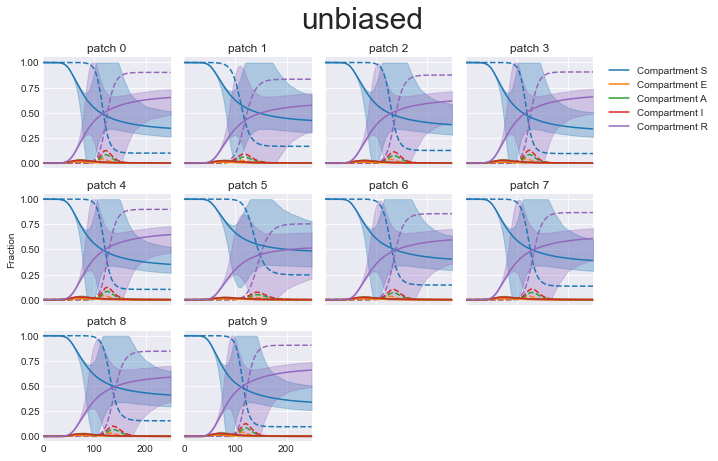

In [10]:
compare_to_ref(ref_traj_1,trajs_1, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

# Applying MaxEnt

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0231 - weight-entropy: 6.5986
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0193 - weight-entropy: 6.2525
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0201 - weight-entropy: 6.2163
Epoch 4/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0197 - weight-entropy: 6.2196
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0184 - weight-entropy: 6.2356
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0161 - weight-entropy: 6.2456
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0120 - weight-entropy: 6.1936
Epoch 8/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0095 - weight-entropy: 5.8350
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0086 - weight-entropy: 5.5811
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 4.0051
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 3.9872
Epoch 81/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0048 - weight-entropy: 4.4472
Epoch 82/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0039 - weight-entropy: 4.1203
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 4.1413
Epoch 84/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0040 - weight-entropy: 3.8575
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 3.9445
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 3.7245
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 4.1017
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.004

4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.8985
Epoch 158/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.1974
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.2873
Epoch 160/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 4.0177
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.6599
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.5221
Epoch 163/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 3.4315
Epoch 164/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.5031
Epoch 165/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.6144
Epoch 166/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.5409
Epoch 236/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.3597
Epoch 237/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 3.4664
Epoch 238/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.1513
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 2.9567
Epoch 240/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 3.0738
Epoch 241/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.4813
Epoch 242/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.2090
Epoch 243/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0032 - weight-entropy: 3.4904
Epoch 244/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.6586
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0022 - weight-entropy: 2.9503
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.0515
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.8603
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.7536
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.0101
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.8913
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.8206
Epoch 320/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.6902
Epoch 321/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.6471
Epoch 391/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.6763
Epoch 392/500
4/4 [==============================] - ETA: 0s - loss: 0.0015 - weight-entropy: 2.66 - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.7146
Epoch 393/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.0503
Epoch 394/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 3.0346
Epoch 395/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 3.0734
Epoch 396/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.4258
Epoch 397/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.5084
Epoch 398/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 2.5328
Epoch 399/500
4/4 [==

4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.3610
Epoch 468/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.6252
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.5693
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.6295
Epoch 471/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 2.6512
Epoch 472/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.5602
Epoch 473/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.5859
Epoch 474/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.7388
Epoch 475/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.4762
Epoch 476/500
4/4 [==============================] - 0s 2ms/step - lo

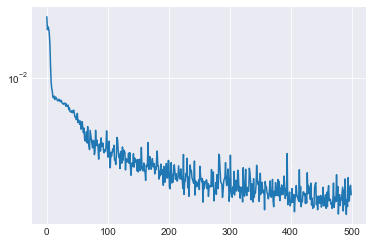

In [11]:
def maxent_fit(trajs,restraints):
    me_model = maxentep.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=1024,epochs=500)
    plt.plot(me_history.history['loss'])
    plt.yscale('log')
    plt.show()
    plt.plot(me_history.history['weight-entropy'])
    return me_model
me_model_1 = maxent_fit(trajs_1, restraints_1)

In [12]:
def compare_patches(ref_traj, trajs,weights_dict, method, restrained_patches,plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()


Plotting 10 patches in a 3 x 4 grid


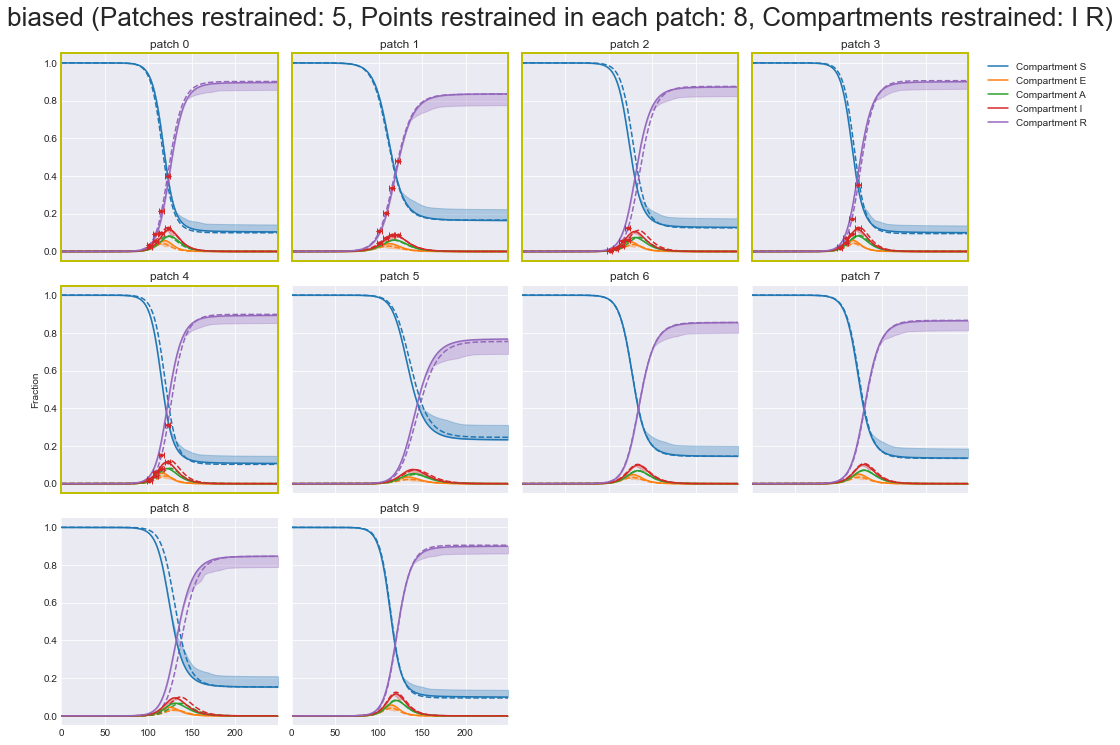

In [13]:
weights_dict_1 = {'unbiased':None, 'biased':me_model_1.traj_weights}
compare_patches(ref_traj_1, trajs_1, weights_dict_1,'biased', restrained_patches_1,plot_fxns_list_1,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

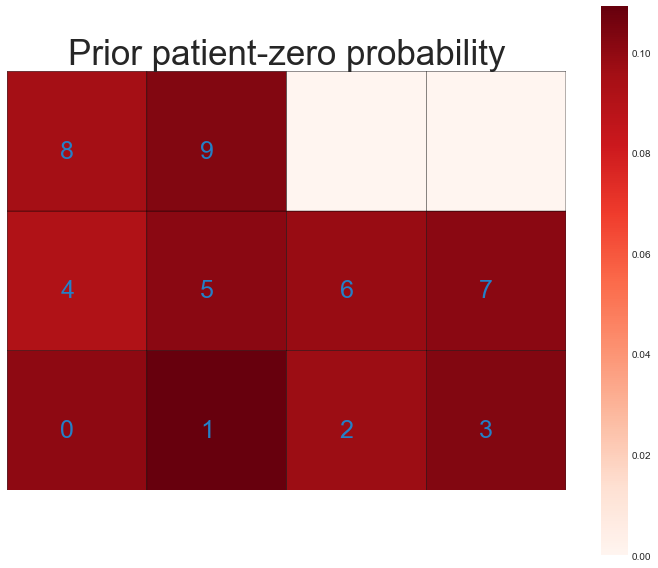

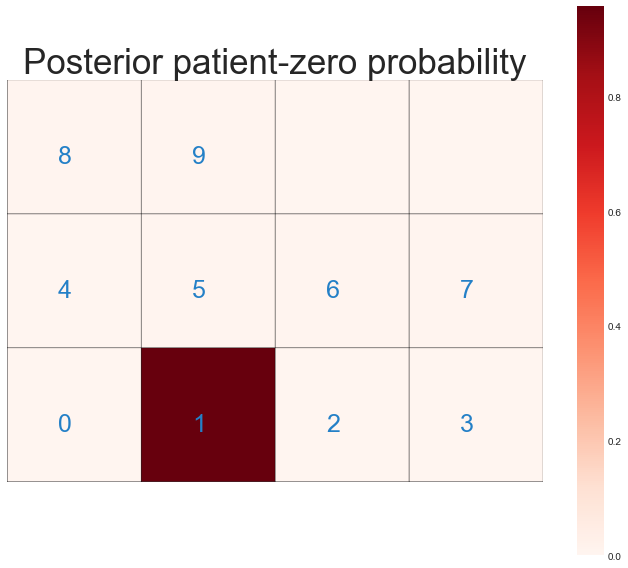

In [14]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
me_w_1 = me_model_1.traj_weights
maxentep.p0_map(prior_exposed_patch_1, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_1, M, weights = me_w_1, title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

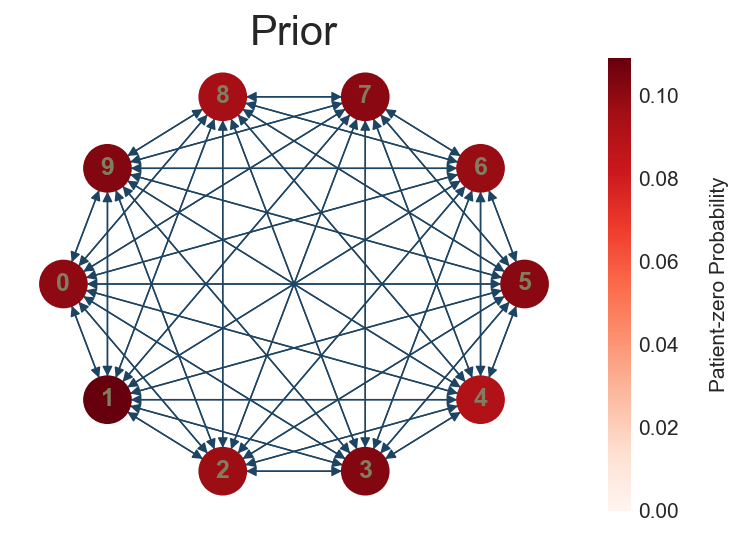

In [15]:
exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M)
weighted_exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M, weights=me_w_1)
maxentep.draw_graph(graph_1, weights=exposed_prob_1, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_1, weights=weighted_exposed_prob_1, title='Posterior', heatmap=True)

In [48]:
def p0_loss(trajs, weights, M=10, true_p0_node=1):
    '''Returns cross-entropy loss for p0 based on sampled trajs and maxent weights inputs'''
    prior_exposed_patch = maxentep.exposed_finder(trajs)
    weighted_exposed_prob = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch, M, weights=weights)
    loss = -np.log(weighted_exposed_prob[true_p0_node])
    return loss


def traj_loss(ref_traj, trajs, weights, skipped_time = 10):
    '''Returns KL divergence loss for predicted traj based on ref_traj, sampled trajs and maxent weights inputs'''
    M = trajs.shape[2]
    Time = trajs.shape[1]
    c = trajs.shape[-1]
    weights /= tf.reduce_sum(weights)
    mtrajs_counties = tf.reduce_sum(trajs * weights[:, tf.newaxis, tf.newaxis,tf.newaxis], axis=0)
    loss = -tf.reduce_sum(ref_traj*tf.math.log(tf.math.divide_no_nan(mtrajs_counties,ref_traj) + 1e-10))/M/Time
    return loss

In [53]:
traj_loss_1 = traj_loss(ref_traj_1, trajs_1, me_w_1)
p0_loss_1 = p0_loss(trajs_1,me_w_1)
# posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print(f'P0 cross-entropy : {p0_loss_1:.3f}, Traj KL : {traj_loss_1:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_1, patches), reverse=True)[:5])


P0 cross-entropy : 0.043, Traj KL : 0.002
Top 5 posterior probabilities for P0: 
 [(0.9576492002275081, 'patch 1'), (0.007322073995850634, 'patch 9'), (0.0068824870160291264, 'patch 5'), (0.006376198187619304, 'patch 8'), (0.005608636819906944, 'patch 6')]


 # Case 2

6.9

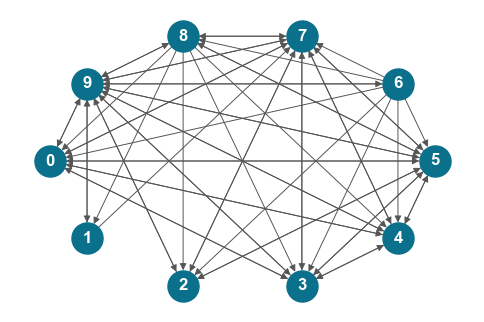

In [20]:
graph_2, edge_list_2, node_list_2 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)
graph_2.remove_edges_from([(1, i) for i in range(0,7) if i!=1])
graph_2.remove_edges_from([(i, 1) for i in range(0,8)  if i!=1])
graph_2.remove_edges_from([(2, i) for i in range(0,5) if i!=2])
graph_2.remove_edges_from([(i,2) for i in range(0,5)  if i!=2])
graph_2.remove_edges_from([(i,8) for i in range(0,5)  if i!=8])
graph_2.remove_edges_from([(i,6) for i in range(0,9)  if i!=6])
maxentep.draw_graph(graph_2, dpi=100)
# nx.draw(graph_2, with_labels=True, pos=nx.shell_layout(graph_2) , font_weight='bold', ax=ax, **options)
dof_2 = maxentep.graph_dof(graph_2.edges(), node_list_2)
dof_2

In [21]:
def sparse_graph_mobility(sparse_graph, fully_connected_mobility_matrix):
    R'''
    Generates a sprase mobility matrix based on a sparse graph and a fully connected mobility matrix inputs
    '''
    sparse_mobility_matrix = np.zeros_like(fully_connected_mobility_matrix)
    for i, edge in enumerate(sparse_graph.edges()):
        sparse_mobility_matrix[edge[0], edge[1]] = fully_connected_mobility_matrix[edge[0], edge[1]]
    return sparse_mobility_matrix


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


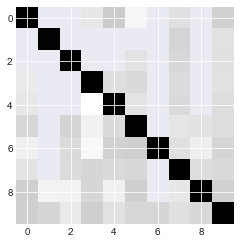

In [22]:
sparse_mobility_matrix_2 = sparse_graph_mobility(graph_2, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_2))
sparse_ref_traj_2 = gen_ref_traj(M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_2)
maxentep.patch_quantile(sparse_ref_traj_2, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

In [23]:
restraints_2, plot_fxns_list_2, restrained_patches_2 = gen_restraints(sparse_ref_traj_2)

Restraints are set in this time range: [100, 130]
115 0.10540361 0.10429922623441265
108 0.061291493 0.06134365855469814
122 0.120776124 0.12003656130218122
101 0.026829911 0.02837292599131414
101 0.042077936 0.04157304002379087
122 0.43633083 0.4358860672877964
115 0.24324894 0.24362607571002845
108 0.10875301 0.10811590413073087
122 0.0120278215 0.012420129559235491
108 0.0016564392 0.0018980739618951357
115 0.004590985 0.004694920811829031
101 0.00057700824 0.0
108 0.0024070926 0.0017311926696753988
122 0.018957015 0.018034468801464747
115 0.006881315 0.006432728449767701
101 0.0008227728 0.0010047518948559494
101 0.053787287 0.05488694692055409
108 0.07896448 0.0796197429983198
122 0.079048894 0.07968902587185794
115 0.08983905 0.0882220926393325
115 0.38220358 0.3835865212834353
101 0.13148151 0.13186842621934666
108 0.23989142 0.2385589715956383
122 0.526785 0.5272888335442849
108 0.0031417892 0.003663776961054763
115 0.009099903 0.010297162450006782
122 0.024537044 0.02415455743

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.27s/it]


Plotting 10 patches in a 3 x 4 grid


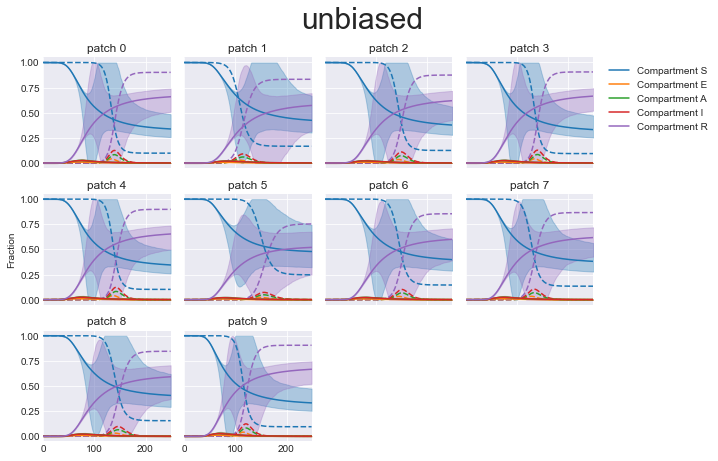

In [26]:
sparse_trajs_2 = gen_samples(sparse_mobility_matrix_2, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_2, sparse_trajs_2, weights=None, method='unbiased',
               patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0268 - weight-entropy: 6.6171
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0171 - weight-entropy: 6.2454
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0179 - weight-entropy: 6.1856
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0180 - weight-entropy: 6.1692
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0180 - weight-entropy: 6.1658
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0180 - weight-entropy: 6.1706
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0178 - weight-entropy: 6.1800
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0175 - weight-entropy: 6.1933
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0171 - weight-entropy: 6.2084
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.0035
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.8937
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.8872
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.0238
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.5781
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 3.3206
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.4194
Epoch 86/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 3.6261
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 3.6653
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.004

4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 2.4879
Epoch 158/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 2.5087
Epoch 159/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 2.3214
Epoch 160/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.5570
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.9535
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 3.0205
Epoch 163/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.8004
Epoch 164/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.3727
Epoch 165/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.7274
Epoch 166/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 2.1244
Epoch 236/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.2151
Epoch 237/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.9430
Epoch 238/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.5999
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 1.7957
Epoch 240/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 2.1656
Epoch 241/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 2.3906
Epoch 242/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 1.9973
Epoch 243/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.2380
Epoch 244/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.3621
Epoch 314/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 1.9645
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.1633
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.6839
Epoch 317/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 1.8279
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 2.5767
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 2.3250
Epoch 320/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 1.7800
Epoch 321/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 1.8616
Epoch 322/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 2.0132
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 2.3938
Epoch 393/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.1029
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.2272
Epoch 395/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 1.7768
Epoch 396/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 1.7264
Epoch 397/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 2.1934
Epoch 398/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 1.7302
Epoch 399/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 1.7433
Epoch 400/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 1.7763
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 1.8143
Epoch 471/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 2.7505
Epoch 472/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 1.8912
Epoch 473/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 2.0981
Epoch 474/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 2.1845
Epoch 475/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 1.8581
Epoch 476/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 1.7869
Epoch 477/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 1.9458
Epoch 478/500
4/4 [==============================] - 0s 2ms/step - lo

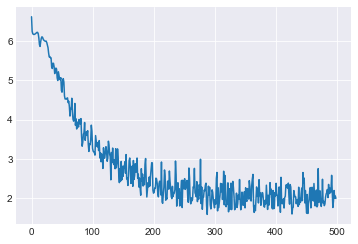

In [27]:
sparse_me_model_2 = maxent_fit(sparse_trajs_2, restraints_2)

Plotting 10 patches in a 3 x 4 grid


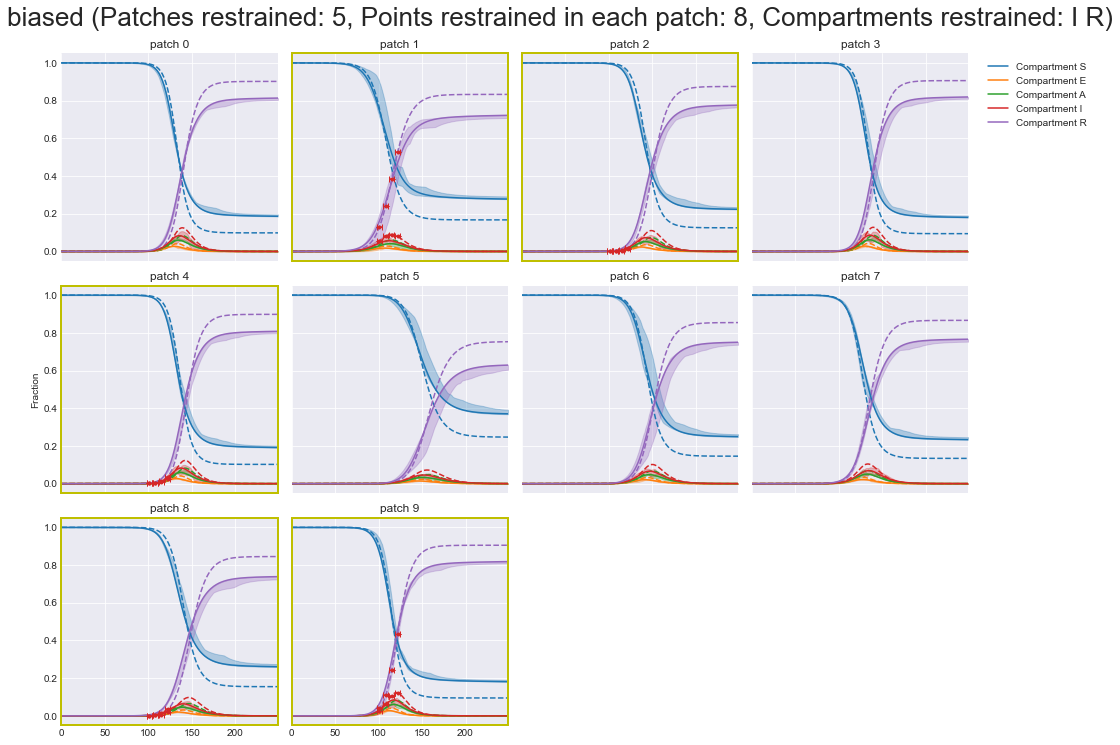

In [28]:
weights_dict_2 = {'unbiased':None, 'biased':sparse_me_model_2.traj_weights}
compare_patches(sparse_ref_traj_2, sparse_trajs_2, weights_dict_2,'biased', restrained_patches_2, plot_fxns_list_2,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

In [29]:
me_w_2 = sparse_me_model_2.traj_weights
prior_exposed_patch_2 = maxentep.exposed_finder(sparse_trajs_2)
maxentep.p0_map(prior_exposed_patch_2, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_2, M, weights = me_w_2, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

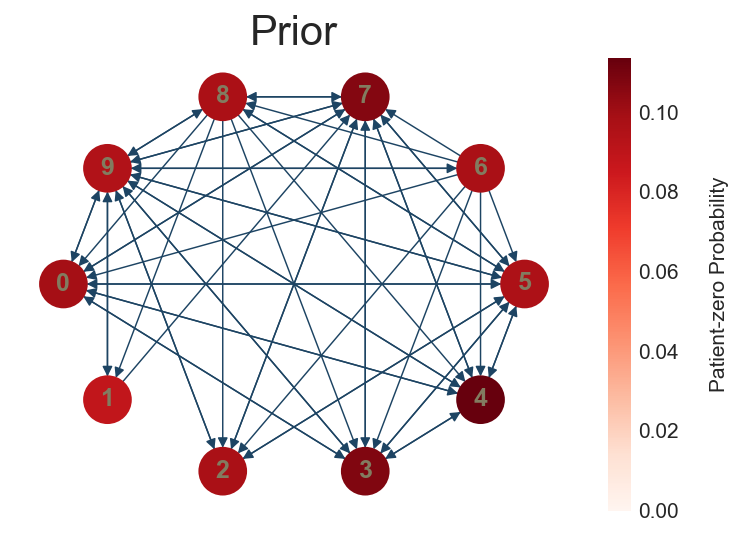

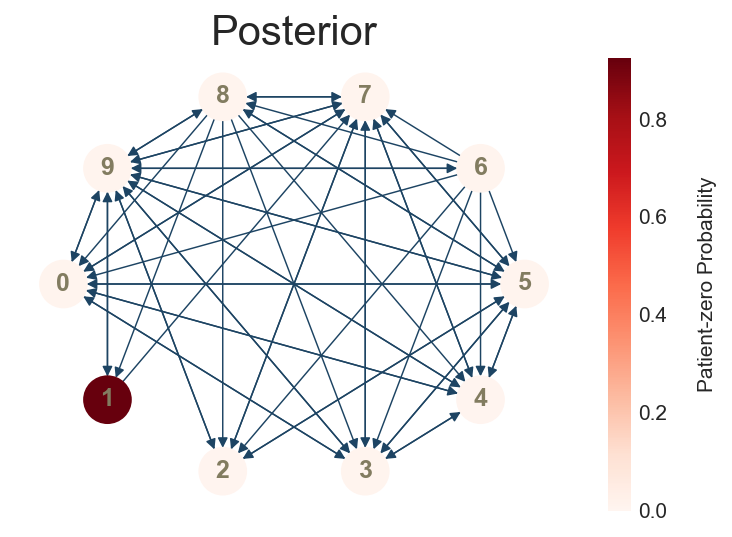

In [30]:
exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M)
weighted_exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M, weights=me_w_2)
maxentep.draw_graph(graph_2, weights=exposed_prob_2, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_2, weights=weighted_exposed_prob_2, title='Posterior', heatmap=True)

In [54]:
traj_loss_2 = traj_loss(sparse_ref_traj_2, sparse_trajs_2, me_w_2)
p0_loss_2 = p0_loss(sparse_trajs_2,me_w_2)
print(f'P0 cross-entropy : {p0_loss_2:.3f}, Traj KL : {traj_loss_2:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_2, patches), reverse=True)[:5])

P0 cross-entropy : 0.077, Traj KL : 0.017
Top 5 posterior probabilities for P0: 
 [(0.9260039230351848, 'patch 1'), (0.009666815296589979, 'patch 7'), (0.009315123681794924, 'patch 5'), (0.0090698747855578, 'patch 6'), (0.008881268927702128, 'patch 9')]


# Case 3

4.5

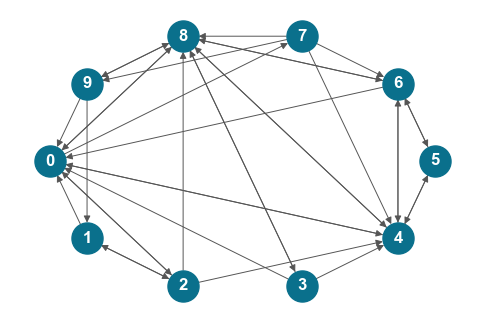

In [55]:
graph_3, edge_list_3, node_list_3 = maxentep.gen_graph(10)
graph_3.remove_edges_from([(1, i) for i in range(3,9)])
graph_3.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i != 1])
graph_3.remove_edges_from([(i, 2) for i in range(3,9) ])
graph_3.remove_edges_from([(i, 6) for i in range(0,4)])
graph_3.remove_edges_from([(i, 7) for i in range(1,10) if i != 7])
graph_3.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_3.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_3.remove_edges_from([(9,i) for i in range(2,8)])
graph_3.remove_edges_from([(i,9) for i in range(0,7)])
# graph.remove_edges_from([(i,4) for i in range(0,7)])
maxentep.draw_graph(graph_3,dpi=100)
dof_3 = maxentep.graph_dof(graph_3.edges(), node_list_3)
dof_3


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


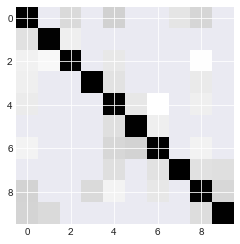

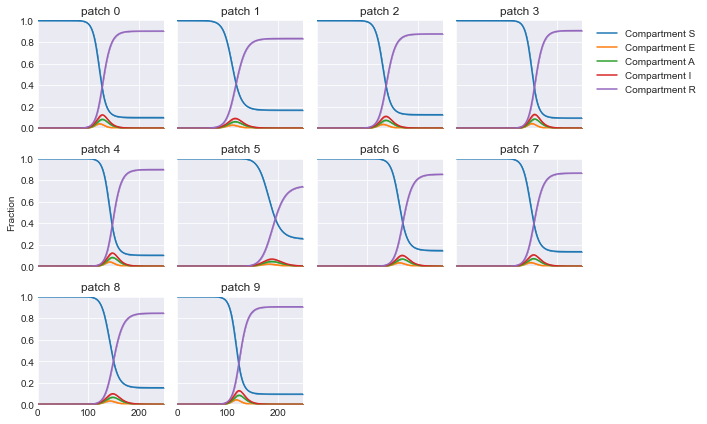

In [56]:
sparse_mobility_matrix_3 = sparse_graph_mobility(graph_3, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_3))
sparse_ref_traj_3 = gen_ref_traj(M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_3)
maxentep.patch_quantile(sparse_ref_traj_3, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [100, 130]
108 0.05076637 0.050774337464197766
115 0.09697069 0.0980592651960632
101 0.020690132 0.020769110235137285
122 0.12428466 0.12509074463816558
108 0.08426815 0.08315914808059538
115 0.20113523 0.20033229937268596
101 0.031141803 0.032015936163021
122 0.38814515 0.38828020538239877
101 0.00033131754 0.0012071503018455001
108 0.0009822365 0.0008671289978832963
122 0.0075553097 0.008012725289305479
115 0.0028076486 0.0018430366059031648
115 0.004078666 0.004793023398877905
101 0.00045773902 0.00021667154587457708
108 0.0013826654 0.001206706542834388
122 0.011567414 0.012578875530104516
101 0.009924008 0.009655752833029349
108 0.026211465 0.02491360965705059
115 0.060189243 0.060785296297652294
122 0.104445554 0.10358017888424954
115 0.106328905 0.10404126470279607
108 0.04104476 0.040493286370231606
101 0.014788656 0.015996276229217826
122 0.23893516 0.23778335959058883
108 0.07932959 0.07849570776811036
122 0.07875639 0.07711288865010475


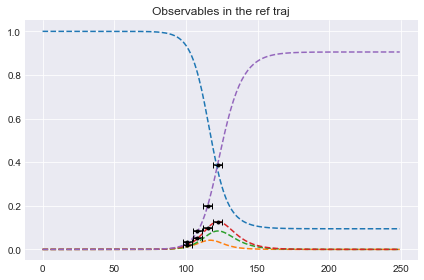

In [62]:
restraints_3, plot_fxns_list_3, restrained_patches_3 = gen_restraints(sparse_ref_traj_3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.24s/it]


Plotting 10 patches in a 3 x 4 grid


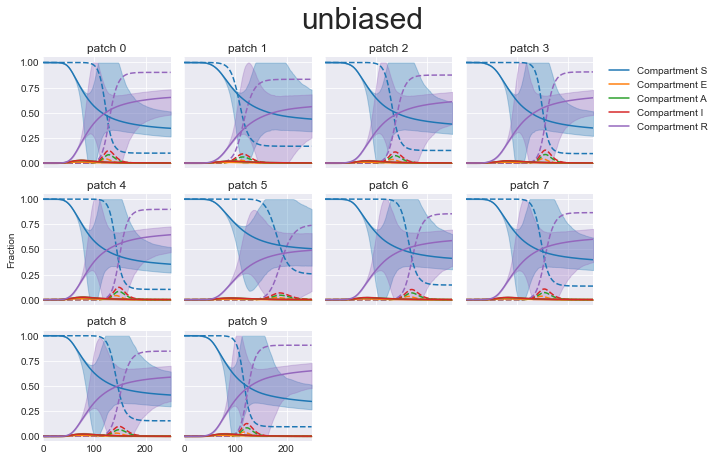

In [58]:
sparse_trajs_3 = gen_samples(sparse_mobility_matrix_3, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_3, sparse_trajs_3, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0228 - weight-entropy: 6.6415
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0176 - weight-entropy: 6.3126
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0184 - weight-entropy: 6.2620
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0186 - weight-entropy: 6.2509
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0185 - weight-entropy: 6.2532
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0182 - weight-entropy: 6.2628
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0178 - weight-entropy: 6.2767
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0172 - weight-entropy: 6.2913
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0164 - weight-entropy: 6.2958
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 4.4146
Epoch 79/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0057 - weight-entropy: 4.8216
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 4.6209
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 4.3855
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 4.2287
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 4.6557
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 4.8414
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 4.5821
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0064 - weight-entropy: 4.5449
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.005

4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.2593
Epoch 156/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.4924
Epoch 157/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.4063
Epoch 158/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 4.3965
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 4.4604
Epoch 160/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 4.4743
Epoch 161/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0034 - weight-entropy: 4.2970
Epoch 162/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 4.2838
Epoch 163/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0043 - weight-entropy: 4.5470
Epoch 164/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0034 - weight-entropy: 4.1792
Epoch 234/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1013
Epoch 235/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.3908
Epoch 236/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 4.7769
Epoch 237/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.0285
Epoch 238/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 3.9633
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 4.0750
Epoch 240/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0039 - weight-entropy: 4.2778
Epoch 241/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1777
Epoch 242/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.3464
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.0332
Epoch 312/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 4.1443
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.0667
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 4.2713
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1875
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 4.1295
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 4.5104
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.2808
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.8493
Epoch 389/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.9306
Epoch 390/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.2111
Epoch 391/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 4.3060
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 3.8942
Epoch 393/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0041 - weight-entropy: 3.9023
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 4.0118
Epoch 395/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.9108
Epoch 396/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 4.4045
Epoch 397/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 3.9827
Epoch 467/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.2599
Epoch 468/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.7205
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 4.1498
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1214
Epoch 471/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.9534
Epoch 472/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.7957
Epoch 473/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 3.8565
Epoch 474/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.8564
Epoch 475/500
4/4 [==============================] - 0s 2ms/step - lo

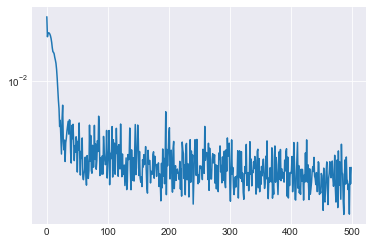

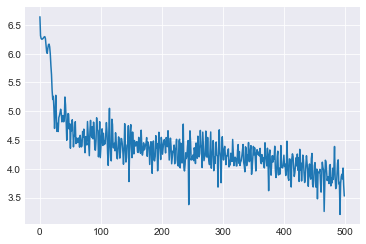

In [63]:
sparse_me_model_3 = maxent_fit(sparse_trajs_3, restraints_3)

In [64]:
me_w_3 = sparse_me_model_3.traj_weights
weights_dict_3 = {'unbiased':None, 'biased':me_w_3}
compare_patches(sparse_ref_traj_3, sparse_trajs_3, weights_dict_3,'biased', restrained_patches_3, plot_fxns_list_3,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

Plotting 10 patches in a 3 x 4 grid


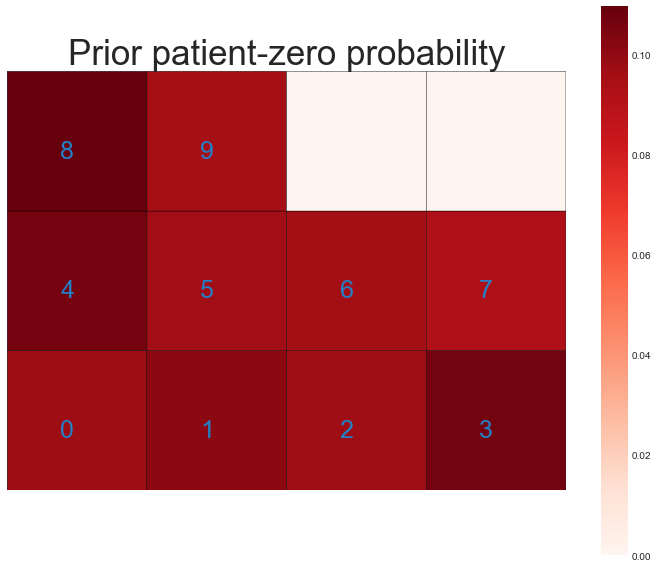

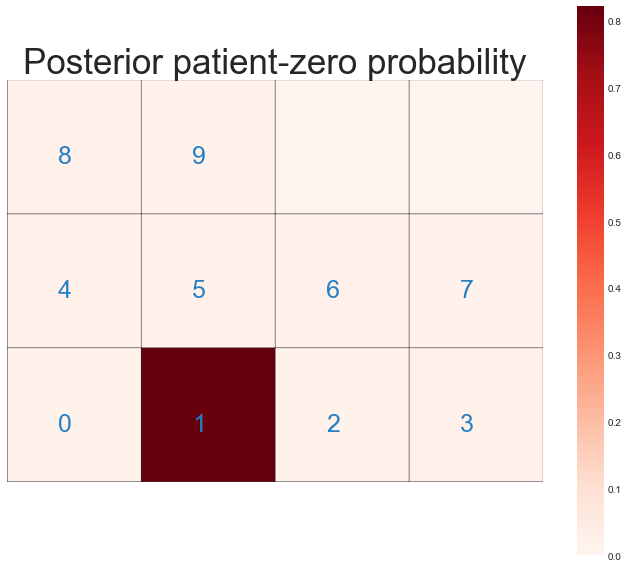

In [65]:
prior_exposed_patch_3 = maxentep.exposed_finder(sparse_trajs_3)
maxentep.p0_map(prior_exposed_patch_3, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_3, M, weights = me_w_3, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

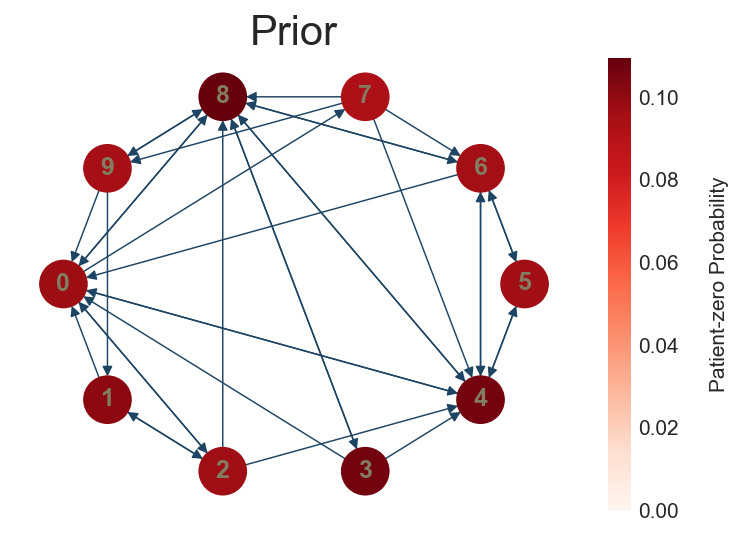

In [66]:
exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M)
weighted_exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M, weights=me_w_3)
maxentep.draw_graph(graph_3, weights=exposed_prob_3, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_3, weights=weighted_exposed_prob_3, title='Posterior', heatmap=True)

In [67]:
traj_loss_3 = traj_loss(sparse_ref_traj_3, sparse_trajs_2, me_w_3)
p0_loss_3 = p0_loss(sparse_trajs_3,me_w_3)
print(f'P0 cross-entropy : {p0_loss_3:.3f}, Traj KL : {traj_loss_3:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_3, patches), reverse=True)[:5])

P0 cross-entropy : 0.197, Traj KL : 0.237
Top 5 posterior probabilities for P0: 
 [(0.821600742548289, 'patch 1'), (0.02530470497006948, 'patch 5'), (0.0237196193209462, 'patch 8'), (0.0233083768916277, 'patch 3'), (0.021515386423877743, 'patch 6')]


# Case 4

3.3

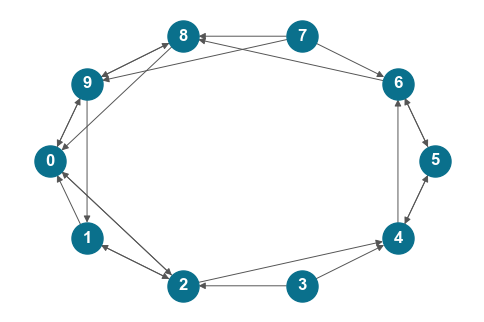

In [68]:
graph_4, edge_list_4, node_list_4 = maxentep.gen_graph(10)
graph_4.remove_edges_from([(1, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i!=1])
graph_4.remove_edges_from([(i, 2) for i in range(4,9)])
graph_4.remove_edges_from([(i, 6) for i in range(0,4)])
graph_4.remove_edges_from([(i, 7) for i in range(1,10) if i!=7])
graph_4.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_4.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5] )
graph_4.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_4.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_4.remove_edges_from([(9,i) for i in range(2,8)])
graph_4.remove_edges_from([(i,9) for i in range(1,7)])
graph_4.remove_edges_from([(0, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 0) for i in range(3,8)])
graph_4.remove_edges_from([(i, 8) for i in range(2,6)])
graph_4.remove_edges_from([(8, i) for i in range(1,8) if i!=7 and i!=8])
graph_4.remove_edges_from([(i, 4) for i in range(6,9)])
maxentep.draw_graph(graph_4, dpi=100)
dof_4 = maxentep.graph_dof(graph_4.edges(), node_list_4)
dof_4

In [69]:
sparse_mobility_matrix_4 = sparse_graph_mobility(graph_4, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_4))
sparse_ref_traj_4 = gen_ref_traj(M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=sparse_mobility_matrix_4)
maxentep.patch_quantile(sparse_ref_traj_4, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


Restraints are set in this time range: [100, 130]
108 0.07932925 0.0784722513534861
122 0.078763604 0.07955272684903965
101 0.054222208 0.05286006959485961
115 0.08986384 0.09109146967395546
115 0.38459417 0.38592195493526155
101 0.13276814 0.1326668577569085
108 0.24189411 0.2410909696499127
122 0.5289672 0.5285028640183118
101 7.917837e-05 0.0
115 0.0007420485 0.00023175575115888438
122 0.0022340838 0.002418009327513227
108 0.00024347428 0.0
122 0.0031064537 0.0006293562752079378
101 0.00010706105 0.00019336542386052147
108 0.00033195416 0.0016138733443700989
115 0.0010204159 0.0005500244248890106
101 6.0882405e-07 0.0
115 5.736271e-06 0.0
122 1.7318545e-05 0.0
108 1.8792001e-06 0.0
108 2.548648e-06 0.0
115 7.867091e-06 0.002510512539232508
122 2.4010425e-05 0.0002868060525257733
101 8.155206e-07 0.0
108 5.5390883e-06 0.0
115 1.7005586e-05 0.0
122 5.090108e-05 0.0018058872325357445
101 1.7702583e-06 0.0
108 7.409675e-06 0.00011004483333943438
115 2.3147892e-05 0.0
122 7.086686e-05 0.

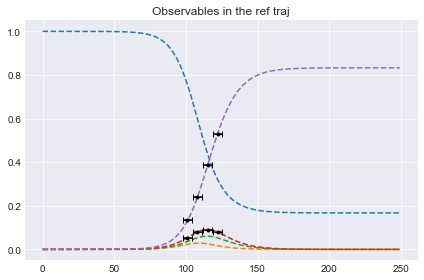

In [74]:
restraints_4, plot_fxns_list_4, restrained_patches_4 = gen_restraints(sparse_ref_traj_4)

In [75]:
sparse_trajs_4 = gen_samples(sparse_mobility_matrix_4, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_4, sparse_trajs_4, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.20s/it]


Plotting 10 patches in a 3 x 4 grid


Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0187 - weight-entropy: 6.7120
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 6.4226
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0118 - weight-entropy: 6.3527
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0119 - weight-entropy: 6.3241
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0120 - weight-entropy: 6.3104
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0120 - weight-entropy: 6.3045
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0119 - weight-entropy: 6.3031
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0119 - weight-entropy: 6.3053
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0118 - weight-entropy: 6.3096
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.5641
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 9.5592e-04 - weight-entropy: 4.4670
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.6555
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.5467
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 4.6333
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.5248
Epoch 85/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 4.5683
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.4792
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.4730
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 9.9372e-04 - weight-entropy: 3.9216
Epoch 156/500
4/4 [==============================] - 0s 2ms/step - loss: 6.8581e-04 - weight-entropy: 3.7438
Epoch 157/500
4/4 [==============================] - 0s 2ms/step - loss: 7.8003e-04 - weight-entropy: 3.8513
Epoch 158/500
4/4 [==============================] - 0s 2ms/step - loss: 8.8878e-04 - weight-entropy: 3.9627
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.0415
Epoch 160/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.9586
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.0873
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 9.5124e-04 - weight-entropy: 3.8011
Epoch 163/500
4/4 [==============================] - 0s 2ms/step - loss: 8.3232e-04 - weight-entropy: 3.6334
Epoch 164/500
4/4 [==========================

4/4 [==============================] - 0s 1ms/step - loss: 8.6020e-04 - weight-entropy: 3.8851
Epoch 231/500
4/4 [==============================] - 0s 2ms/step - loss: 7.9545e-04 - weight-entropy: 3.6402
Epoch 232/500
4/4 [==============================] - 0s 2ms/step - loss: 8.4269e-04 - weight-entropy: 3.7846
Epoch 233/500
4/4 [==============================] - 0s 2ms/step - loss: 7.8301e-04 - weight-entropy: 3.4934
Epoch 234/500
4/4 [==============================] - 0s 3ms/step - loss: 6.9992e-04 - weight-entropy: 3.5757
Epoch 235/500
4/4 [==============================] - 0s 2ms/step - loss: 8.2349e-04 - weight-entropy: 3.7234
Epoch 236/500
4/4 [==============================] - 0s 1ms/step - loss: 7.2238e-04 - weight-entropy: 3.5271
Epoch 237/500
4/4 [==============================] - 0s 1ms/step - loss: 6.4098e-04 - weight-entropy: 3.6848
Epoch 238/500
4/4 [==============================] - 0s 2ms/step - loss: 7.0157e-04 - weight-entropy: 3.8209
Epoch 239/500
4/4 [==============

4/4 [==============================] - 0s 2ms/step - loss: 7.0156e-04 - weight-entropy: 3.7382
Epoch 306/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7535e-04 - weight-entropy: 3.6462
Epoch 307/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.8257
Epoch 308/500
4/4 [==============================] - 0s 1ms/step - loss: 6.5742e-04 - weight-entropy: 3.6290
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 6.6723e-04 - weight-entropy: 3.6030
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 8.8627e-04 - weight-entropy: 3.7108
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 7.0149e-04 - weight-entropy: 3.7322
Epoch 312/500
4/4 [==============================] - 0s 2ms/step - loss: 5.8718e-04 - weight-entropy: 3.4922
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 5.8957e-04 - weight-entropy: 3.5534
Epoch 314/500
4/4 [==================

4/4 [==============================] - 0s 1ms/step - loss: 5.6122e-04 - weight-entropy: 3.4321
Epoch 381/500
4/4 [==============================] - 0s 1ms/step - loss: 5.7208e-04 - weight-entropy: 3.4045
Epoch 382/500
4/4 [==============================] - 0s 1ms/step - loss: 6.7972e-04 - weight-entropy: 3.5779
Epoch 383/500
4/4 [==============================] - 0s 2ms/step - loss: 7.0226e-04 - weight-entropy: 3.5767
Epoch 384/500
4/4 [==============================] - 0s 1ms/step - loss: 7.9620e-04 - weight-entropy: 3.3977
Epoch 385/500
4/4 [==============================] - 0s 1ms/step - loss: 8.4528e-04 - weight-entropy: 3.6273
Epoch 386/500
4/4 [==============================] - 0s 2ms/step - loss: 6.7666e-04 - weight-entropy: 3.4493
Epoch 387/500
4/4 [==============================] - 0s 1ms/step - loss: 8.0543e-04 - weight-entropy: 3.3774
Epoch 388/500
4/4 [==============================] - 0s 1ms/step - loss: 6.7328e-04 - weight-entropy: 3.4632
Epoch 389/500
4/4 [==============

4/4 [==============================] - 0s 2ms/step - loss: 6.2020e-04 - weight-entropy: 3.2174
Epoch 455/500
4/4 [==============================] - 0s 2ms/step - loss: 7.0454e-04 - weight-entropy: 3.3759
Epoch 456/500
4/4 [==============================] - 0s 2ms/step - loss: 4.8634e-04 - weight-entropy: 3.2676
Epoch 457/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2939e-04 - weight-entropy: 3.4547
Epoch 458/500
4/4 [==============================] - ETA: 0s - loss: 0.0010 - weight-entropy: 4.50 - 0s 2ms/step - loss: 5.2595e-04 - weight-entropy: 3.3403
Epoch 459/500
4/4 [==============================] - 0s 1ms/step - loss: 5.0914e-04 - weight-entropy: 3.1943
Epoch 460/500
4/4 [==============================] - 0s 2ms/step - loss: 4.6016e-04 - weight-entropy: 3.3122
Epoch 461/500
4/4 [==============================] - 0s 2ms/step - loss: 6.0588e-04 - weight-entropy: 3.3919
Epoch 462/500
4/4 [==============================] - 0s 2ms/step - loss: 4.2794e-04 - weight-e

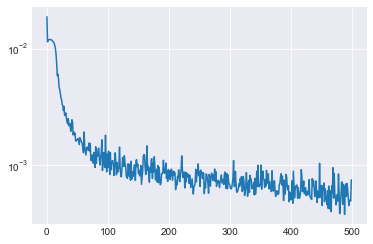

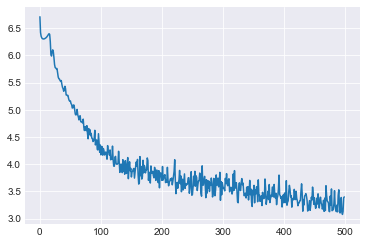

In [76]:
sparse_me_model_4 = maxent_fit(sparse_trajs_4, restraints_4)

In [77]:
me_w_4 = sparse_me_model_4.traj_weights
weights_dict_4 = {'unbiased':None, 'biased':me_w_4}
compare_patches(sparse_ref_traj_4, sparse_trajs_4, weights_dict_4,'biased', restrained_patches_4, plot_fxns_list_4,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

Plotting 10 patches in a 3 x 4 grid


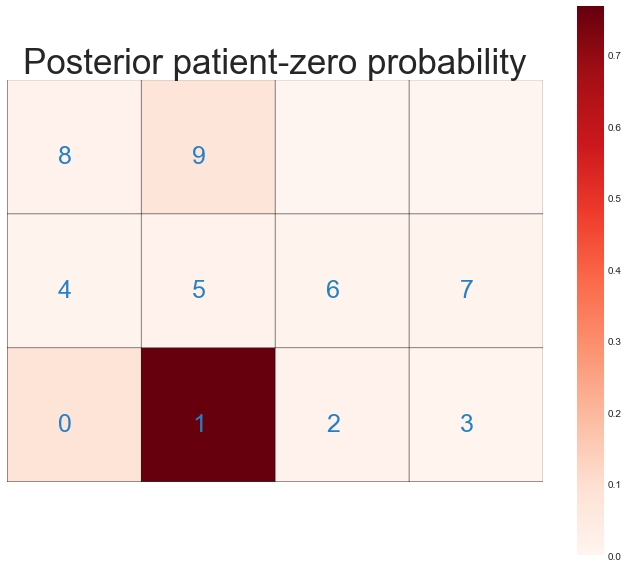

In [78]:
prior_exposed_patch_4 = maxentep.exposed_finder(sparse_trajs_4)
maxentep.p0_map(prior_exposed_patch_4, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_4, M, weights = me_w_4, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))


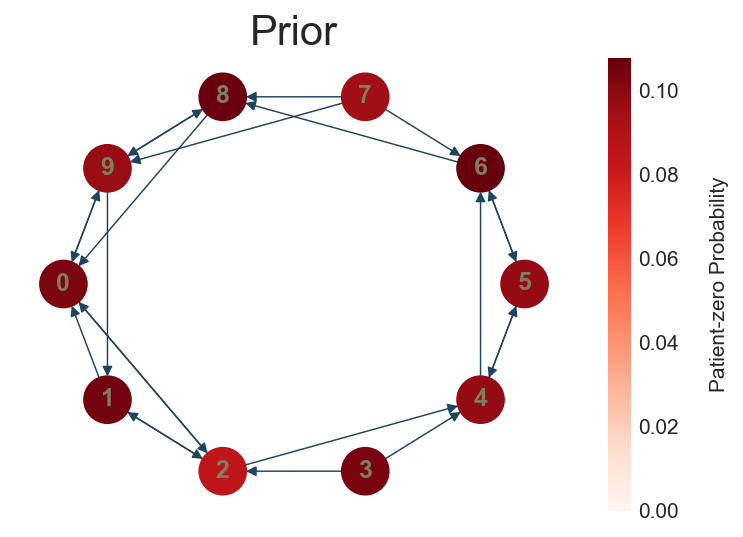

In [79]:
exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M)
weighted_exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M, weights=me_w_4)
maxentep.draw_graph(graph_4, weights=exposed_prob_4, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_4, weights=weighted_exposed_prob_4, title='Posterior', heatmap=True)

In [80]:
traj_loss_4 = traj_loss(sparse_ref_traj_4, sparse_trajs_4, me_w_4)
p0_loss_4 = p0_loss(sparse_trajs_4,me_w_4)
print(f'P0 cross-entropy : {p0_loss_4:.3f}, Traj KL : {traj_loss_4:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_4, patches), reverse=True)[:5])

P0 cross-entropy : 0.265, Traj KL : 0.031
Top 5 posterior probabilities for P0: 
 [(0.7675548118898186, 'patch 1'), (0.08241282855756697, 'patch 0'), (0.07249668548766797, 'patch 9'), (0.014350582136484621, 'patch 8'), (0.013295430759049206, 'patch 5')]


Text(0, 0.5, 'Certainty in the Origin of Patinet-zero ')

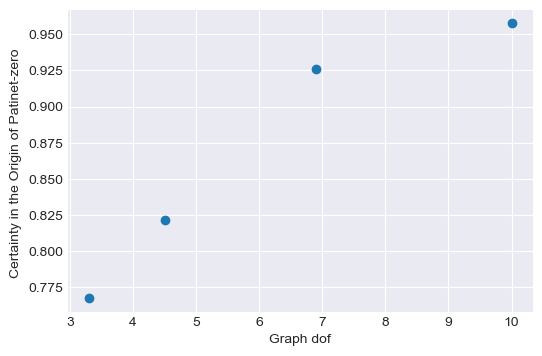

In [81]:
p0_probs = [max(weighted_exposed_prob_1),max(weighted_exposed_prob_2),max(weighted_exposed_prob_3),max(weighted_exposed_prob_4)]
dofs = [dof_1, dof_2, dof_3, dof_4]
fig, ax = plt.subplots(dpi=100)
plt.scatter(dofs,p0_probs)
ax.set_xlabel('Graph dof')
ax.set_ylabel('Certainty in the Origin of Patinet-zero ')